## From Your Favorite Book to Your Favorite Podcast
Insight Fellowship・Data Demonstration<br/>
Carl Huang ( http://carlhuang.com )<br/>
Nov 9, 2020

* Send raw data through ETL pipline
* Understand data through SQL queries and visualization 
* Build a simple recommendation model from book to podcast episode

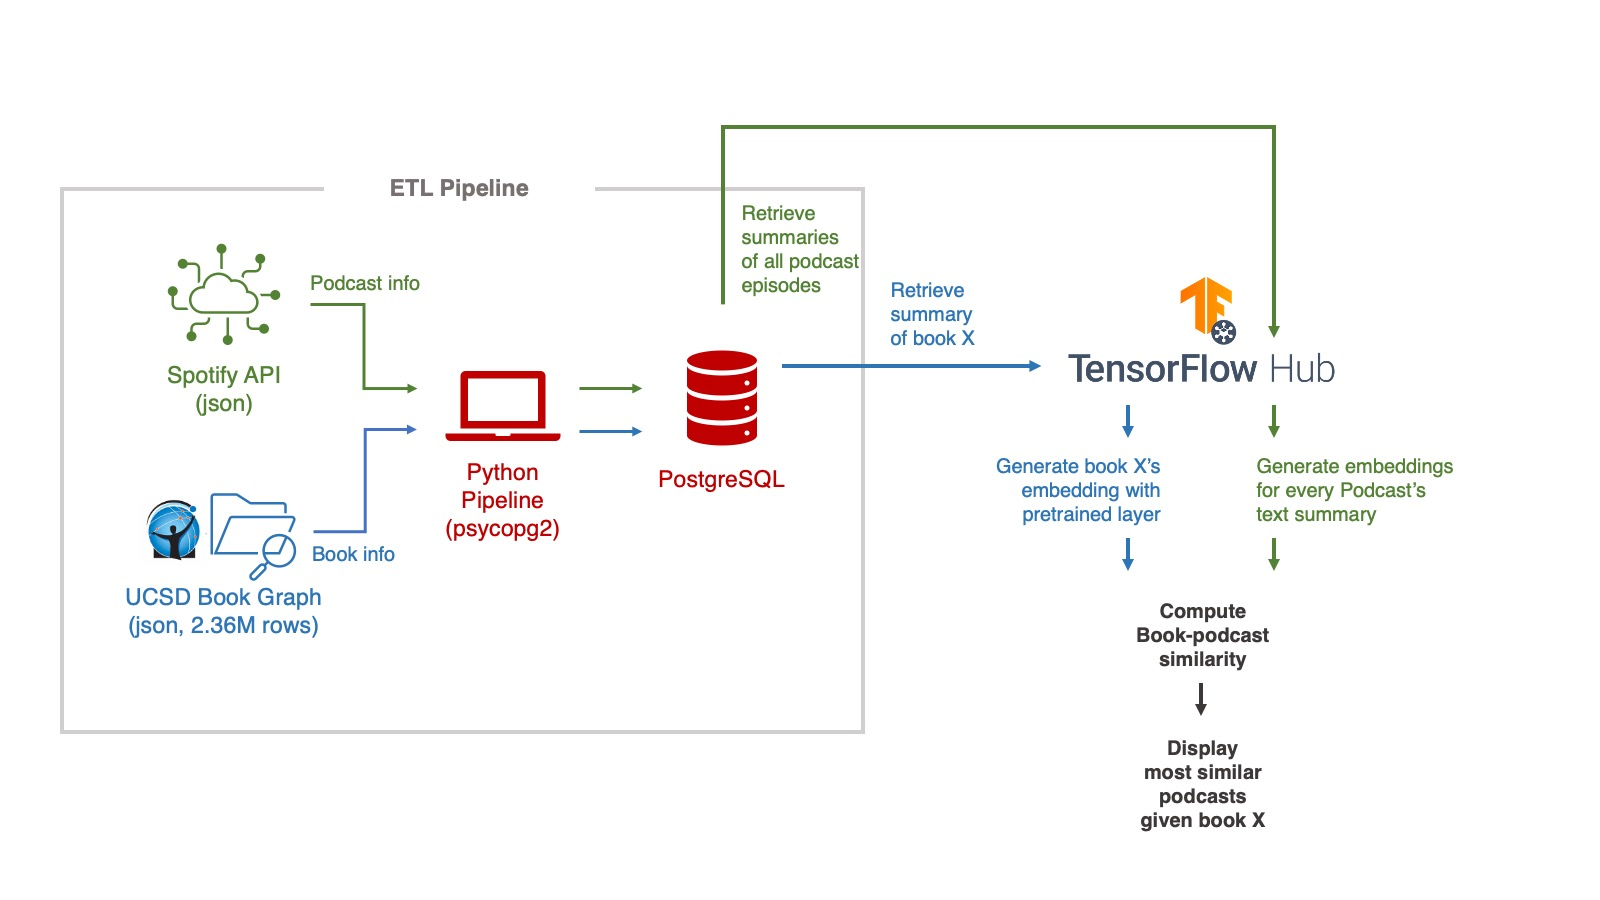

In [1]:
# Display image in jupyter notebook interface
from IPython.display import Image
Image(filename='architecture.jpg')

In [2]:
import re
import time
import json
import configparser
import psycopg2
import random
import logging
import string

import spacy
parser = spacy.load("en_core_web_lg")
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth

import pandas as pd
import seaborn as sns
import tensorflow as tf
from langdetect import detect
from datetime import datetime

sns.set_theme(style="darkgrid")
pd.options.mode.chained_assignment = None
logging.getLogger('tensorflow').disabled = True

## 1. Data Pipeline
### 1.1 Using class to handle ETL
Since both the `Spotify API` and `UCSD Book Graph` pipelines involves (1) extracting JSON data, (2) transform data, and (3) loading data into PostgreSQL, I will build a general class to reduce redundant codes:

In [3]:
class etl_handler(object):
    "A class that loads a JSON file, transform data, and insert data into PostgreSQL tables"
    def __init__(self):
        self.config = '/Users/Carl/_data Science/_project/book to podcast/database.ini'
        self.data = None
    
    def psql_insert(self):
        return self.insert_table


    # Loading functions
    def load_json(self, json_file: str, max_line = None):
        """Takes:   the path of a JSON file to be loaded, and many lines should be loaded.
                    (some large JSON files might not be fit into memory)
           Returns: None, but saves loaded data into a list of dictionaries in self.data"""
        data = []
        count = 0
        with open(json_file, 'r') as f:
            for line in f:
                dict_ = json.loads(line)
                data.append(dict_)
                count += 1
                if max_line:
                    if count == max_line:
                        break
            self.data = pd.DataFrame(data)

    # Data wrangling/cleaning functions
    def get_data(self, rows: int = None, random_draw: bool = False, seed: int = None):
        """Takes:  (rows) the number of rows to be displayed,
                   (random_draw, seed) whether these rows should be produced by a random draw
           Returns: a pandas DataFrame with specifications above."""
        if self.data is not None:
            if not rows:
                # If 'row' is not given, the all rows from self.data will be read.
                rows = self.data.shape[0]
            if random_draw:
                if seed:
                    return self.data.sample(n=rows, random_state=seed)
            else:
                return self.data[:rows]
        else:
            print("Error. Data not loaded. User load_json() to load data first.")
    
    def select_columns(self, cols: list):
        self.data = self.data[cols]
    
    def add_column(self, col_name, content):
        self.data[col_name] = content
    
    def filter_value(self, column, value, how = None):
        if how == '==':
            self.data = self.data.loc[self.data[column] == value]

        if how == '>=':
            self.data = self.data.loc[self.data[column] >= value]

        if how == '>':
            self.data = self.data.loc[self.data[column] > value]

        if how == '<=':
            self.data = self.data.loc[self.data[column] <= value]

        if how == '<':
            self.data = self.data.loc[self.data[column] < value]

        
    def column_function(self, cols: list, func):
        for col in cols:
            new_col = self.data[col].map(func)
            self.data.loc[:, col] = new_col

    
    def drop_na(self):
        self.data = self.data.dropna()
    
    # PSQL functions
    def psql_connect(self):
        "Given a confige file (config.ini), this function locates information PostgreSQL "
        config = configparser.ConfigParser()
        config.read(self.config)
        connection = psycopg2.connect(
            host = config['postgres']['host'],
            database = config['postgres']['database'],
            user = config['postgres']['user'],
            password = config['postgres']['password']
            )
        cursor = connection.cursor()
        return connection, cursor


### 1.1.1 Loading Book Data from UCSD Book Graph

In [ ]:
class bookgraph_etl(etl_handler):
    def __init__(self):
        super().__init__()
        self.create_table = ("""CREATE TABLE IF NOT EXISTS book(
                                book_id bigint PRIMARY KEY,
                                year smallint NOT NULL,
                                rating_counts int NOT NULL,
                                title varchar(250) NOT NULL UNIQUE,
                                description varchar(500),
                                authors varchar(250),
                                language varchar(20))""")
        
        self.insert_table = ("""INSERT INTO book 
                               (book_id, year, rating_counts, title, description, authors, language)
                               VALUES (%s, %s, %s, %s, %s, %s, %s)
                               ON CONFLICT DO NOTHING""")
        
    def psql_create(self):
        return self.create_table

    def psql_insert(self):
        return self.insert_table
        
bookgraph = bookgraph_etl()
bookgraph.load_json('/Users/Carl/_data Science/_data/UCSD Bookgraph/goodreads_books.json', max_line = 10_000)

In [ ]:
bookgraph.get_data(rows=5)

### 1.1.2 Select Relevant Columns, Set Data Type
The original `bookgraph` data has 29 columns.

In [ ]:
bookgraph.get_data().columns

To provide users recommendation and relevant information, I trim down the original data into these columns below, and separate them based on "numeric" and "categorical":

In [ ]:
int_cols = ['book_id', 'publication_year', 'ratings_count']
str_cols = ['title', 'description', 'authors']
bookgraph.select_columns(int_cols+str_cols)

In [ ]:
def int_transform(text):
    return int(text) if text != '' else None

def str_transform(text):
    return text if len(text) != 0 else None

bookgraph.column_function(int_cols, int_transform)
bookgraph.column_function(str_cols, str_transform)

### 1.1.3 Dealing with NaNs and Nones

In [ ]:
bookgraph.drop_na()

### 1.1.4 Increase `authors` column usability

In [ ]:
# Global variable so the same author_data will not be loaded multiple times
global author_data
# The same etl_handler() can do most of the work:
author_data = etl_handler()
author_data.load_json('/Users/Carl/_data Science/_data/UCSD Bookgraph/goodreads_book_authors.json')
author_data.select_columns(['author_id','name'])
author_data = author_data.get_data().set_index('author_id')

def get_author_name(author_id: str):
    "Takes a Bookgraph author_id and returns the author's actual name"
    # [0] selects the text of an author's name without the entire pd.Series    
    return author_data.loc[author_id][0]

def get_authors(authors: list, max_len = 250):
    "Takes a list of author dictionaries, find main author, and return a list of authors in text"
    temp = list()
    for author in authors:
        # In Bookgraph, default author role is ''. Only contributors/illustrators/translators are specified
        if author.get('role') == '':
            author_id = author.get('author_id')
            author_name = get_author_name(author_id)
            temp.append(author_name)
    return ', '.join(temp)[:max_len]

In [ ]:
author_data.head()

In [ ]:
bookgraph.column_function(['authors'], get_authors)

### 1.1.5 Clean Up Title and Text Description

In [ ]:
sns.displot(bookgraph.get_data(), x=bookgraph.get_data().description.transform(lambda x: len(x)))

#### Unusually short descriptions
A quick glance reveals that descriptions with a length shorter than 50 is rather noisy without much information that might be useful to set up a recommendation system. So for this test I decide to remove examples with descriptions like these later on.

In [ ]:
print(bookgraph.get_data().loc[bookgraph.get_data().description.map(len)< 50]['description'].to_list())

#### Unusually long descriptions
By contrast, very long descriptions are long, but they

In [ ]:
bookgraph.get_data().description.map(len).max()

In [ ]:
long_text = bookgraph.get_data().loc[bookgraph.get_data().description.map(len)==6350]['description'].to_list()
long_text

In [ ]:
def standardize_description(text, max_len=500, min_len = 50):
    text = text.replace('\n',' ')
    text = text.replace("\'",'')
    text = re.sub('^https?:\/\/.*[\r\n]*', '', text)
    text = re.sub('^http?:\/\/.*[\r\n]*', '', text)
    text = re.sub('\s+?', ' ', text)
    text = text.strip()
    # rsplit(maxsplit=1)[0] takes away only the right-most part of text separated by '. '
    text = text[:max_len].rsplit('. ', maxsplit=1)[0]
    if len(text) < min_len:
        return None
    else:
        return text
    
def standardize_title(x):
    return standardize_description(x, max_len=250, min_len = 1)

In [ ]:
bookgraph.column_function(['description'], standardize_description)
bookgraph.column_function(['title'], standardize_title)

In [ ]:
bookgraph.drop_na()
data = bookgraph.get_data().copy()
sns.displot(data, x = data.description.map(lambda x: len(x)))

Language

In [ ]:
now = datetime.now()
language_col = bookgraph.get_data().description.map(lambda x: detect(x) if x is not None else None)
# Language detection is rather time-consuming and computationally expensive
print(datetime.now() - now)
bookgraph.add_column('language', language_col)

In [ ]:
data.language.hist()

In [ ]:
bookgraph.filter_value(column='language', value='en', how='==')

### 1.1.6 Narrowing Years

In [ ]:
bookgraph.filter_value(column='publication_year', value=1980, how='>=')
bookgraph.filter_value(column='publication_year', value=2020, how='<=')

In [ ]:
sns.displot(data, x='publication_year')

### 1.1.7 Insert into PostgreSQL

In [ ]:
conn, cur = bookgraph.psql_connect()

In [ ]:
cur.execute(bookgraph.psql_create())
conn.commit()

In [ ]:
for i, row in bookgraph.get_data().iterrows():
    cur.execute(bookgraph.psql_insert(), row)
    conn.commit()

In [ ]:
conn.close()

### 1.2.1. Loading Podcasts

In [ ]:
class podcast_etl(bookgraph_etl):

    def __init__(self):
        super().__init__()
        self.spotify_connection = None
        self.create_table = ("""CREATE TABLE IF NOT EXISTS show(
                                show_id text PRIMARY KEY NOT NULL,
                                name varchar text NOT NULL,
                                external_url text NOT NULL, 
                                image_url text NOT NULL, 
                                language text NOT NULL,
                                publisher text NOT NULL,
                                total_episodes int NOT NULL,
                                description varchar(500) NOT NULL
                                )""")
        
        self.insert_table = ("""INSERT INTO show 
                        (show_id, external_url, image_url, language, name, publisher, total_episodes, description)
                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                        ON CONFLICT (show_id)
                        DO UPDATE SET total_episodes = EXCLUDED.total_episodes""")
            
    def spotify_connect(self):
        "Build connection with the Spotify API"
        
        config = configparser.ConfigParser()
        config.read(self.config)
        scope = "user-library-read"
        
        sp = spotipy.Spotify(auth_manager = SpotifyOAuth(scope=scope, 
                                                         client_id = config['spotify']['client_id'], 
                                                         client_secret = config['spotify']['client_secret'],
                                                         redirect_uri='http://nuthatch.carlhuang.com'))
        self.spotify_connection = sp
        return "connection established"
    
    def parse_data(self, results):
        pd_temp = list()
        cols = ['id', 'name','publisher','total_episodes','description','external_urls', 'images']        
        for item in results['shows']['items']:
            d = {}
            for col in cols:
                try:
                    d[col] = item[col]
                    d['external_urls'] = item['external_urls']['spotify']
                    d['images'] = item['images'][-1]['url']
                    d['languages'] = item['languages'][0]
                    pd_temp.append(d)
                except:
                    continue
        return pd_temp
    
    def load_show(self, key='.+', target_rows = target_rows, type = 'Show', random_search = False):
        "Type can either be show (podcast) or episode"
        # Spotify API limits 50 rows of query per second
        sp = self.spotify_connection
        count = 0
        offset = 0
        loaded_data = []
        
        def legal_query(key):
            temp = []
            for i in range(0, target_rows, 50):
                if offset % 100 == 0:
                    print('Retrieving rows {}/{} with key {}'.format(i, target_rows, key))
                    results = sp.search(key, market = 'US', limit = 50, offset = i, type = type)
                    temp += self.parse_data(results)
                    time.sleep(1)
            return temp
        
        if not random_search:
            loaded_data += legal_query(key)
            
        else:
            alph = list(string.ascii_lowercase)
            while len(alph) > 0:
                rdn_key = alph.pop(alph.index(random.choice(alph)))
                new_rows = legal_query(rdn_key)
                count += len(new_rows)
                loaded_data += new_rows
#                 offset = 0
#                 if count >= target_rows:
#                     break
        self.data = pd.DataFrame(loaded_data)
        return self.data

In [ ]:
podcasts = podcast_etl()
podcasts.spotify_connect()

In [ ]:
podcasts.load_show(target_rows = 2000, type="show", random_search = True)

In [ ]:
podcasts.drop_na()
podcasts.column_function(['description'], standardize_description)

In [ ]:
podcasts.drop_na()


In [ ]:
conn, cur = podcasts.psql_connect()

In [ ]:
cur.execute(podcasts.psql_create())
conn.commit()

In [ ]:
for i, row in podcasts.get_data().iterrows():
    cur.execute(podcasts.psql_insert(), row)
    conn.commit()

In [ ]:
conn.close()

### 1.2.2. Loading Episodes

In [ ]:
class episode_etl(podcast_etl):

    def __init__(self):
        super().__init__()
        self.create_table = ("""CREATE TABLE IF NOT EXISTS episode(
                                episode_id text PRIMARY KEY NOT NULL,
                                name text NOT NULL,
                                external_url text NOT NULL, 
                                image_url text NOT NULL, 
                                language text NOT NULL,
                                release_date date NOT NULL,
                                description varchar(500) NOT NULL
                                )""")
        
        self.insert_table = ("""INSERT INTO episode 
                        (episode_id, external_url, image_url, language, name, release_date, description)
                        VALUES (%s, %s, %s, %s, %s, %s, %s)
                        ON CONFLICT (episode_id) DO NOTHING""")
    
    def parse_data(self, results):
        pd_temp = list()
        cols = ['id', 'name','release_date','description','external_urls', 'images']        
        for item in results['episodes']['items']:
            d = {}
            try:
                for col in cols:
                    d[col] = item[col]
                d['external_urls'] = item['external_urls']['spotify']
                d['images'] = item['images'][-1]['url']
                d['languages'] = item['languages'][0]
                pd_temp.append(d)

            except:
                continue
        return pd_temp

In [ ]:
episode = episode_etl()
episode.spotify_connect()

In [ ]:
episode.load_show(target_rows = 2000, type = 'episode', random_search = True)

In [ ]:
episode.get_data()

In [ ]:
episode.drop_na()
episode.column_function(['description'], standardize_description)
episode.drop_na()

In [ ]:
episode.get_data(rows=3)

In [ ]:
conn, cur = episode.psql_connect()

In [ ]:
cur.execute(episode.psql_create())
conn.commit()

In [ ]:
for i, row in episode.get_data().iterrows():
    cur.execute(episode.psql_insert(), row)
    conn.commit()

In [ ]:
conn.close()

## 2. Understanding Data

In [ ]:
%load_ext sql
%sql postgresql://carl@localhost:5432/book_podcast

In [ ]:
%sql SELECT title, description FROM book LIMIT 1;

In [ ]:
%sql SELECT episode_id, name, release_date FROM episode LIMIT 10;

In [ ]:
d = %sql SELECT episode_id, name, release_date FROM episode;

In [ ]:
d[130][1]

## 3. A Simple Recommendation Function

In [ ]:
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
bert = hub.load('https://tfhub.dev/google/experts/bert/wiki_books/2')

In [ ]:
def get_emb(text_list):
    bert_inputs = preprocess(text_list)
    bert_outputs = bert(bert_inputs)
    return bert_outputs['pooled_output']

In [ ]:
episode_descriptions = %sql SELECT description FROM episode;
episode_descriptions = [i[0] for i in episode_descriptions]

episode_name = %sql SELECT name FROM episode;
episode_name = [i[0] for i in episode_descriptions]

episode_emb = get_emb(episode_descriptions)

In [ ]:
def find_podcast(book_embedding):
    "Takes an embedding vector of a book's description, then  "
    cosine_sim = tf.keras.losses.cosine_similarity(book_embedding, episode_emb)
    top_5 = np.argsort(cosine_sim)[:5]
    name = [episode_name[i] for i in top_5]
    des = [episode_descriptions[i] for i in top_5]
    return list(zip(name, des))

def book_match(book_name: str):
    etl = etl_handler()
    conn, cur = etl.psql_connect()
    cur.execute("SELECT * FROM book WHERE title = '{}';".format(book_name))
    data = cur.fetchone()
    if data:
        data = {'book_id':data[0], 'year':data[0], 'title':data[2], 'description':data[3], 
                'authors': data[4], 'language': data[5]}
        title = data['title']
        description = data['description']
        emb = get_emb([description])

        message = """"{}" -- {}. \n\nHere are five Podcast recommendations based on "{}":'
        """.format(title, description, title)
        # picked[['title', 'description']]
        print(message)
        return find_podcast(emb)
    else:
        print('Sorry, no match in our data!')

In [ ]:
book_match('Gardening with a Wild Heart: Restoring Californias Native Landscapes at Home')

## 4. Steps from here

In [ ]:
t1 = "China and Africa have increasing links and high levels of cross-migration. This episode discusses the recent “U-turn” trend in which many Africans are leaving China to return home. It offers a good discussion of various migration, culture and policy issues related to China and Africa, which also apply more broadly."
t2 = "In China in 2018 over 200 million rural migrants worked away from their hometowns, fuelling the country's rapid economic boom. In the 2010s over sixty-one million rural children had at least one parent who had migrated without them, while nearly half had been left behind by both parents. Rachel Murphy draws on her longitudinal fieldwork in two landlocked provinces to explore the experiences of these left-behind children and to examine the impact of this great migration on childhood in China and on family relationships. Using children's voices, Murphy provides a multi-faceted insight into experiences of parental migration, study pressures, poverty, institutional discrimination, patrilineal family culture, and reconfigured gendered and intergenerational relationships."
t3 = "Hidden away since 1930, Laura Ingalls Wilder’s original autobiography reveals the true stories of her pioneering life. Some of her experiences will be familiar; some will be a surprise. Pioneer Girl: The Annotated Autobiography re-introduces readers to the woman who defined the pioneer experience for millions of people around the world."
e1 = get_emb([t1])
e2 = get_emb([t2])
e3 = get_emb([t3])
print(tf.keras.losses.cosine_similarity(e1, e2))
print(tf.keras.losses.cosine_similarity(e1, e3))

In [ ]:
!pip install random-word

In [ ]:
list(string.ascii_lowercase)

In [ ]:
alph = list(string.ascii_lowercase)